In [1]:
import numpy as np
import classiq
from typing import Dict
from matplotlib import pyplot as plt
from classiq import *
from stateprep_qet.utils import (
    amp_to_prob,
    find_angle,
    get_gaussian_amplitude,
    h,
    h_hat,
    normalize,
)
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.qmod.symbolic import sin
import classiq.qmod.symbolic
from math import pi
classiq.qmod.symbolic.pi._expr = str(pi)
print(classiq.__version__)

0.73.0


### Setting parameters

In [2]:
# Parameter of the Gaussian state preparation
NUM_QUBITS = 8  # resolution of input x
EXP_RATE = 1.5  # decay rate of the Gaussian
MIN = -2  # min x
MAX = 2  # max x

# Scaled function definition following the paper
F = lambda x: np.exp(-EXP_RATE * (x**2))  # Gaussian
H_FUNC = h(f=F, min=MIN, max=MAX)
POLY_FUNC = h_hat(h=H_FUNC, h_max=F(0))

# Even and odd part of the function for the mixed parity QSVT
POLY_EVEN = lambda x: (POLY_FUNC(x) + POLY_FUNC(-x))
POLY_ODD = lambda x: (POLY_FUNC(x) - POLY_FUNC(-x))

# Parameter of the QSVT
POLY_DEGREE = 25
POLY_MAX_SCALE = 1

### Define u_sin circuit

In [3]:
@qfunc
def u_sin(
    x: QNum,
    a1: QNum,
):
    a1 *= sin(x / (2**NUM_QUBITS))  # Amplitude encoding sin(x) to |1>
    X(a1)  # sin(x) to |0>

### Define u_f circuit

In [4]:
@qfunc
def projector_cnot(reg: QNum, aux: QBit) -> None:
    control(reg == 0, lambda: X(aux))

@qfunc
def u_f(
    x: QNum,
    a1: QNum,
    a2_qsvt: QBit,
    a3_qsvt: QBit,
):
    """u_{f^{\tilde}} circuit for state preparation using QET (more generally, QSVT)

    Args:
        x (Output[QNum]): _description_
        a1 (Output[QNum]): _description_
        a2_qsvt (Output[QNum]): _description_
        a3_qsvt (Output[QNum]): auxiliary qubit for mixed parity QSVT (NOTE: It is unnecessary if f^{\tilde} has definite parity)
    """

    # Find phase angles
    phiset_even = find_angle(POLY_EVEN, POLY_DEGREE + 3, POLY_MAX_SCALE)
    phiset_odd = find_angle(POLY_ODD, POLY_DEGREE + 2, POLY_MAX_SCALE)

    # Match the length of the phase angles for even and odd parts by adding dummy value
    if len(phiset_even) - 1 == len(phiset_odd):
        phiset_odd = np.append(phiset_odd, [0])
    assert len(phiset_even) == len(phiset_odd)

    # Apply mixed parity QSVT
    full_reg = QArray[QBit]("full_reg")
    bind([a1, x], full_reg)
    within_apply(
        lambda: H(a3_qsvt),
        lambda: qsvt_lcu(
            phase_seq_even=phiset_odd,
            phase_seq_odd=phiset_even,
            proj_cnot_1=lambda reg, aux: projector_cnot(
                reg[0], aux
            ),  # reg==0 representing "from state". If the state is "from state", then mark aux qubit as |1>
            proj_cnot_2=lambda reg, aux: projector_cnot(
                reg[0], aux
            ),  # reg==0 representing "to state". If the state is "to state", then mark aux qubit as |1>
            u=lambda reg: u_sin(
                reg[1 : reg.len], reg[0]
            ),  # reg[1:reg.len] is "x" and reg[0] is "a"
            qvar=full_reg,
            aux=a2_qsvt,
            lcu=a3_qsvt,
        ),
    )
    H(a3_qsvt)
    bind(full_reg, [a1, x])


### Define u_amp circuit

State preparation circuit

In [5]:
@qfunc
def state_prep(reg: QArray[QBit]):
    # reg[0:NUM_QUBITS]: x
    # reg[NUM_QUBITS]: a1
    # reg[NUM_QUBITS + 1]: a2
    # reg[NUM_QUBITS + 2]: a3
    hadamard_transform(reg[0:NUM_QUBITS])
    u_f(reg[0:NUM_QUBITS], reg[NUM_QUBITS], reg[NUM_QUBITS + 1], reg[NUM_QUBITS + 2])


Oracle circuit

In [6]:
@qfunc
def check_block(a: QNum, res: QBit):
    # Mark if the state is good state.
    # Auxiliary qubits are |0> => good state
    res ^= a == 0

$U_{\text{amp}}$ circuit

In [7]:
@qfunc
def u_amp(
    x: QNum,
    a1: QNum,
    a2: QBit,
    a3: QBit,
):
    """Amplitude amplification circuit for state preparation using QET (more generally, QSVT)

    Args:
        x (QNum): Representation of the input x
        a1 (QNum): Auxiliary qubit for the u_sin circuit
        a2 (QBit): Auxiliary qubit for the QSVT circuit
        a3 (QBit): Auxiliary qubit for mixed parity QSVT (NOTE: It is unnecessary if f^{\tilde} has definite parity)
    """
    amp = get_gaussian_amplitude(
        MIN, MAX, mean=0.0, sigma=1.0 / np.sqrt(2 * EXP_RATE)
    )
    print("ampitude:", amp)

    reg = QArray[QBit]("full_reg")
    bind([x, a1, a2, a3], reg)

    exact_amplitude_amplification(
        amplitude=amp,
        oracle=lambda _reg: phase_oracle(
            check_block, _reg[NUM_QUBITS : NUM_QUBITS + 3]
        ),
        space_transform=lambda _reg: state_prep(_reg),
        packed_qvars=reg,
    )

    bind(reg, [x, a1, a2, a3])

### Run

In [ ]:
@qfunc
def main(
    x: Output[QNum],
    a1: Output[QNum],
    a2_qsvt: Output[QBit],
    a3_qsvt_parity: Output[QBit],
):
    allocate(NUM_QUBITS, x)
    allocate(1, a1)
    allocate(1, a2_qsvt)
    allocate(1, a3_qsvt_parity)
    u_amp(x, a1, a2_qsvt, a3_qsvt_parity)

qmod = create_model(
    main,
    constraints=Constraints(max_width=100),
    execution_preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
    preferences = Preferences(timeout_seconds=1800)
)

qprog = synthesize(qmod)
result = execute(qprog).result_value()

ampitude: 0.36670341649895627
[PolyTaylorSeries] (Cheb) max 1.0000330156628245 is at 0.4794169327825695: normalizing
[PolyTaylorSeries] (Cheb) average error = 2.1679192116624055e-05 in the domain [-1, 1] using degree 28
[PolyTaylorSeries] (Cheb) max 1.0000681134236122 is at 0.47943921000693723: normalizing
[PolyTaylorSeries] (Cheb) average error = 4.471261908950233e-05 in the domain [-1, 1] using degree 27


### Check the result

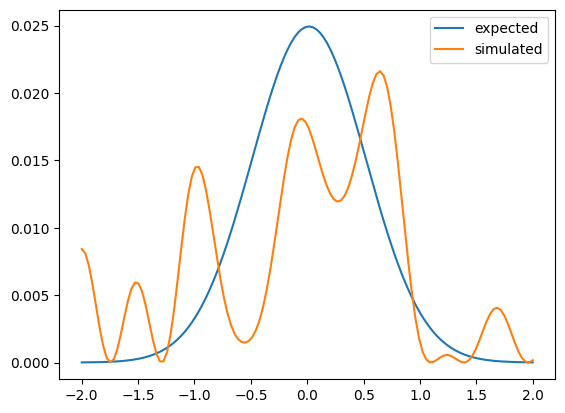

Mean Squared Error (MSE): 4.500262448590792e-05
{'depth': 21629, 'width': 12, 'cx_count': 19572}


In [ ]:
from stateprep_qet.utils import get_metrics

def parse_qsvt_results(result) -> Dict:
    amps: Dict = {x: [] for x in range(2**NUM_QUBITS)}

    for parsed_state in result.parsed_state_vector:
        if (
            parsed_state["a1"] == 0
            and parsed_state["a2_qsvt"] == 0
            and parsed_state["a3_qsvt_parity"] == 0
            and np.linalg.norm(parsed_state.amplitude) > 1e-10
        ):
            amps[parsed_state["x"]].append(parsed_state.amplitude)

    simulated_prob = [amp_to_prob(amp) for amp in amps.values()]
    return simulated_prob

x = np.linspace(MIN, MAX, 2**NUM_QUBITS)
simulated = parse_qsvt_results(result)
expected = normalize(
    [
        amp_to_prob(F(((MAX - MIN) * x / 2**NUM_QUBITS) + MIN))
        for x in range(2**NUM_QUBITS)
    ]
)
plt.plot(x, expected, label="expected")
plt.plot(x, simulated, label="simulated")
plt.legend()
plt.show()

# Calculate MSE between simulated and expected probabilities
mse = np.mean((np.array(simulated) - np.array(expected)) ** 2)
print("Mean Squared Error (MSE):", mse)

# Print circuit metrics
print(get_metrics(qprog))